# Challenge: Clustering Boston marathon runners from 2013

### Basic imports and file read

This data set contains as well managed the entirety of the data on the Boston Marathon available from baa.org for this specific year.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

name = '../../_Datasets/boston_marathon_2013.csv'

In [2]:
df = pd.read_csv(name)
df.head()

25k  age               name  division    10k gender   half  official bib  \
0  49.87   28   Cassidy, Josh R.         9  18.18      M  40.93     90.90  W1   
1  77.27   30      Korir, Wesley         5  30.90      M  64.90    132.50   1   
2  77.23   23     Desisa, Lelisa         1  30.90      M  64.92    130.37   2   
3  50.50   32  Fearnley, Kurt H.         5  18.73      M  42.00     88.43  W2   
4  48.75   39     Hokinoue, Kota         3  18.18      M  40.57     87.22  W3   

   ctz   ...   overall  pace  state    30k     5k genderdiv    20k     35k  \
0  NaN   ...         9  3.47     ON  62.07   8.90         9  38.80   74.73   
1  NaN   ...         5  5.07    NaN  92.97  15.90         5  61.52  108.78   
2  NaN   ...         1  4.98    NaN  92.72  15.93         1  61.53  108.68   
3  NaN   ...         5  3.38    NaN  61.35   8.98         5  39.88   73.00   
4  NaN   ...         3  3.33    NaN  59.92   8.92         3  38.55   71.68   

       city     40k  
0   Toronto   85.55  
1     Kenya  124.77  
2      Ambo  123.78  
3  Hamilton   83.43  
4    Iizuka   81.88  

[5 rows x 21 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16164 entries, 0 to 16163
Data columns (total 21 columns):
25k          16164 non-null object
age          16164 non-null int64
name         16164 non-null object
division     16164 non-null int64
10k          16164 non-null object
gender       16164 non-null object
half         16164 non-null object
official     16164 non-null float64
bib          16164 non-null object
ctz          757 non-null object
country      16164 non-null object
overall      16164 non-null int64
pace         16164 non-null float64
state        14701 non-null object
30k          16164 non-null object
5k           16164 non-null object
genderdiv    16164 non-null int64
20k          16164 non-null object
35k          16164 non-null object
city         16163 non-null object
40k          16164 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 2.6+ MB


#### Data cleaning

Here we drop some of the features we can not use with which to model. We also remove some of the rows with NaN entries.

In [4]:
print(df[df.city.isna()].index, '\n')
df.drop(10138, inplace=True)
df.drop(['ctz', 'state', 'name', 'city', 'country', 'bib'], 1, inplace=True)

for col in df.columns:
    if col in ['gender', 'country', 'city']:
        pass
    else:
        new_col = pd.to_numeric(df[col], errors='coerce')
        df.loc[new_col.index, col] = new_col

df = df.dropna(how='any')

df['gender'] = pd.get_dummies(df.gender, drop_first=True)
# df = pd.concat([pd.get_dummies(df.country, prefix='country', prefix_sep='_'), df], axis=1)
# df.drop('country', 1)

df.info()

Int64Index([10138], dtype='int64') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16053 entries, 0 to 16163
Data columns (total 15 columns):
25k          16053 non-null float64
age          16053 non-null int64
division     16053 non-null int64
10k          16053 non-null float64
gender       16053 non-null uint8
half         16053 non-null float64
official     16053 non-null float64
overall      16053 non-null int64
pace         16053 non-null float64
30k          16053 non-null float64
5k           16053 non-null float64
genderdiv    16053 non-null int64
20k          16053 non-null float64
35k          16053 non-null float64
40k          16053 non-null float64
dtypes: float64(10), int64(4), uint8(1)
memory usage: 1.9 MB


### Review data's ability to talk to us

C:\Users\seapea\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


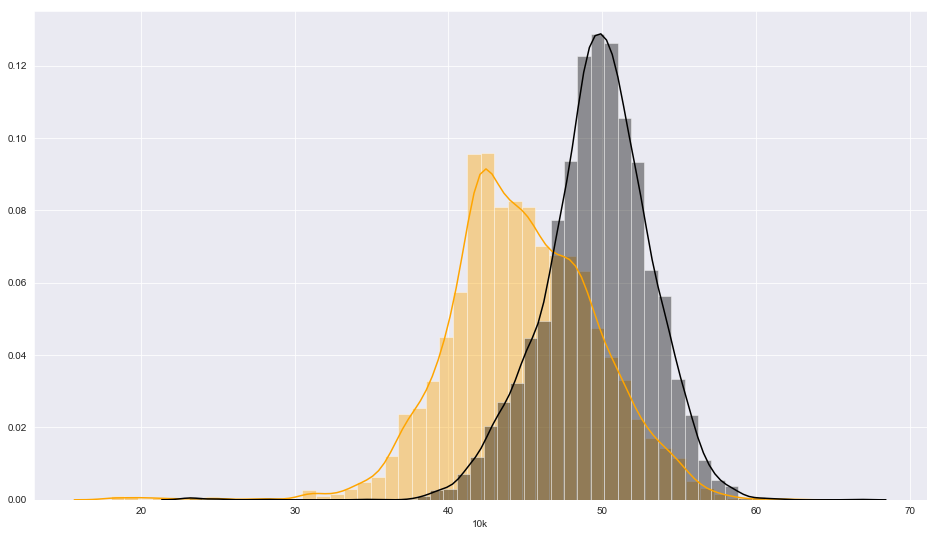

In [5]:
fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(df[df['gender'] == 1]['10k'], color='orange')
sns.distplot(df[df['gender'] == 0]['10k'], color='black')

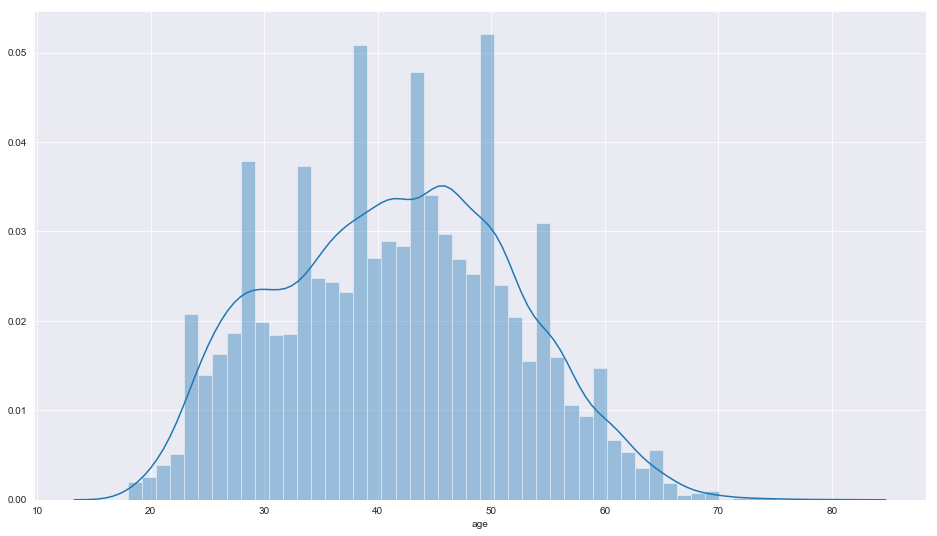

In [6]:
plt.subplots(figsize=(16,9))
sns.distplot(df.age)

### Graphs look good - further imports for clustering and preprocessing

In [10]:
from sklearn.cluster import MiniBatchKMeans, MeanShift, SpectralClustering, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

In [8]:
X_norm = normalize(df)

print(estimate_bandwidth(X_norm))

clf_mbk = MiniBatchKMeans(n_clusters=4).fit(X_norm)
clf_mns = MeanShift(bandwidth=0.227).fit(X_norm)
clf_spec = SpectralClustering(n_clusters=4).fit(X_norm)

df['mini_kmeans_labels'] = clf_mbk.labels_
df['meanshift_labels'] = clf_mns.labels_
df['spectral_labels'] = clf_spec.labels_

mypca = PCA(2).fit_transform(X_norm)
df2 = pd.DataFrame(mypca, index=df.index, columns=['one', 'two'])
df3 = pd.concat([df2, df.loc[:, ['mini_kmeans_labels', 'meanshift_labels', 'spectral_labels']]], 1)

sns.jointplot(x=df3.one, y=df3.two, height=10, ratio=(10))

### Value counts across the cluser outcomes

We are running four clusters, as the bandwidth on the meanshift algorithm works out four.

In [19]:
df.mini_kmeans_labels.value_counts()

0    6615
1    6437
3    2675
2     326
Name: mini_kmeans_labels, dtype: int64

In [20]:
df.meanshift_labels.value_counts()

0    6450
1    6437
2    2896
3     270
Name: meanshift_labels, dtype: int64

In [21]:
df.spectral_labels.value_counts()

2    6490
1    6437
0    2773
3     353
Name: spectral_labels, dtype: int64

### Review clusters and compare

We have run PCA decomposition against the data and assigned cluster labels using mini batch k-means, spectral clustering and meanshift.

Text(0.5,1,'Mini Batch K-Means')

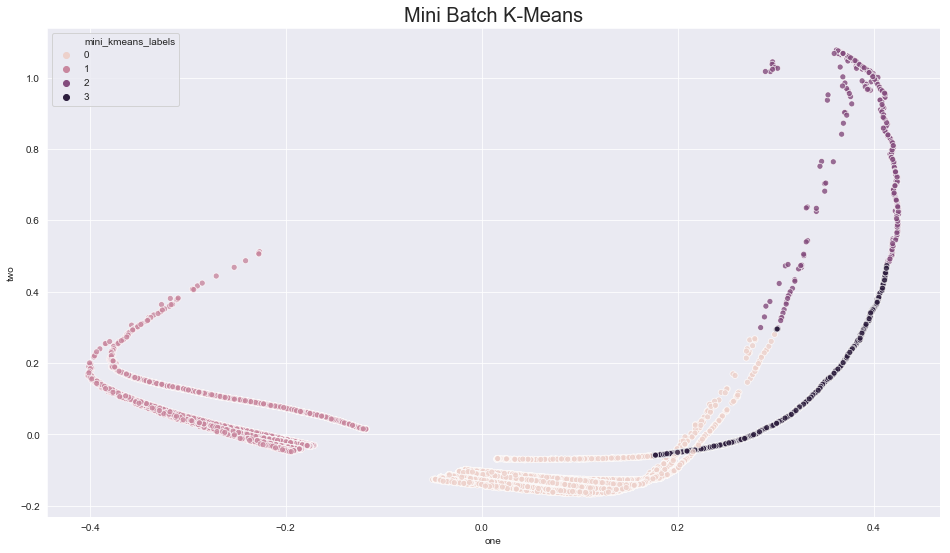

In [127]:
fig, ax = plt.subplots(figsize=(16,9))
sns.scatterplot(data=df3, x='one', y='two', hue='mini_kmeans_labels', alpha=0.8)
ax.set_title('Mini Batch K-Means', size=20)

Text(0.5,1,'Meanshift')

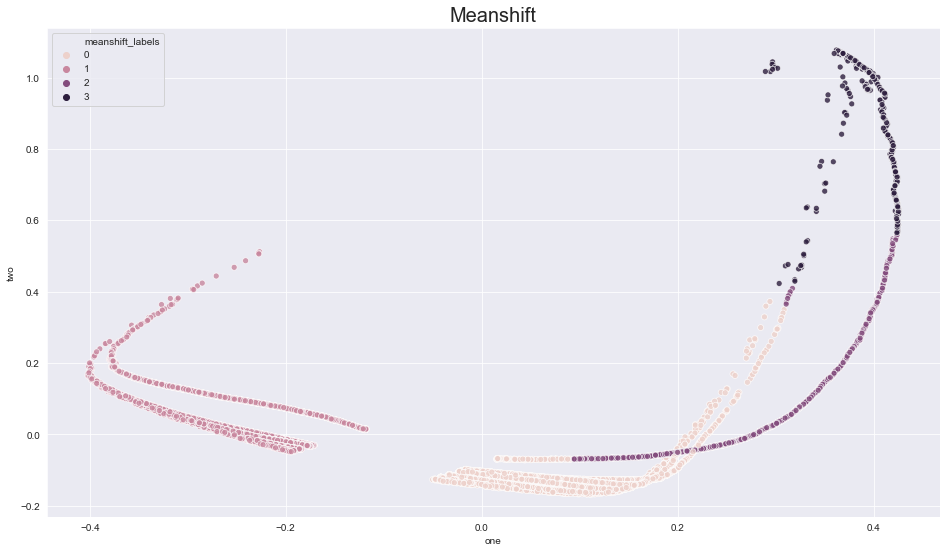

In [126]:
fig, ax = plt.subplots(figsize=(16,9))
sns.scatterplot(data=df3, x='one', y='two', hue='meanshift_labels', alpha=0.8)
ax.set_title('Meanshift', size=20)

Text(0.5,1,'Spectral clustering')

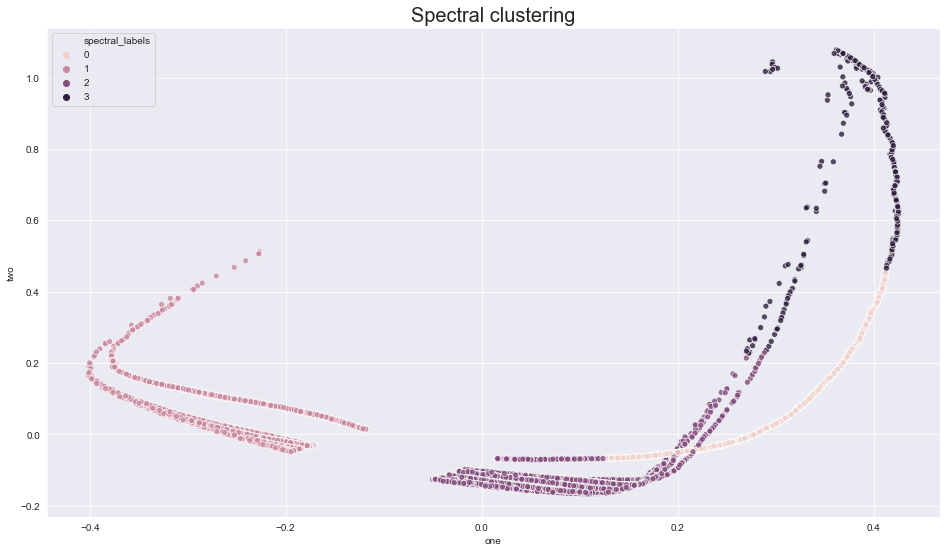

In [125]:
fig, ax = plt.subplots(figsize=(16,9))
sns.scatterplot(data=df3, x='one', y='two', hue='spectral_labels', alpha=0.8)
ax.set_title('Spectral clustering', size=20)

### How do these models compare?

There are lots of similarities in the clusters the algorithms decided. 

The top right split is within one cluster; the bottom right spread is together; the splitting bands are clustered between 0 and 0.2 along the x axis; and lastly the separated left side is clutered. I feel like the separation between clusters is strongest and most consistent in the mini batch k-means - this is the model with which I would proceed.

In [115]:
# for col in df.drop(['meanshift_labels', 'spectral_labels'], 1):
#     sns.factorplot(data=df.drop(['meanshift_labels', 'spectral_labels'], 1), x='mini_kmeans_labels', y=col, kind='box')
#     plt.title(col)
#     plt.show()